### Things to do
#### General Notes
- `airline_sentiment` and possibly `airline_sentiment_confidence` are target columns (the latter cannot be in traning data)
- Remove instance of `"@airline"` tags from text 

####  How to handle each column
**Numerical Columns**
- `negativereason_confidence` -- fill missing data with 0
- `retweet_count` -- remove, almost 100% is just 0

**Categorical Columns**
- `negativereason` -- one hot encode top K reasons +1 column for "other"
- `airline` -- remove or one hot encode with "other" column
- `airline_sentiment_gold` -- remove, almost 100% missing data
- `name` -- remove, unique data
- `negative_reason_gold` -- remove, almost 100% missing data
- `tweet_location` -- remove or one hot encode with "other" column

**Other Columns**
- `tweet_coord` -- remove, almost 100% missing data
- `user_timezone` -- remove, a lot of missing and correlates with location
- `tweet_created` -- convert to columns: day of year (sin/cos), day of week, time of day (sin/cos)
- `text` -- sklearn.feature_extraction.text -> CountVectorizer (?)


# Stage 1: Data Collection and Preparation

**Goal**: Gather and perform an initial analysis of publicly available datasets containing labeled texts with sentiment (positive, negative, neutral) in both Polish and English.

**Dataset**:
- **E2 - Twitter US Airline Sentiment**:
  - [Link to Dataset](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment)

**Tasks**:
1. Conduct an initial data exploration (e.g., number of examples, class distribution).
2. Prepare the data for modeling:
   - Handle missing data.
   - Split the data into training and test sets.

---


In [1]:
!pip install pandas scikit-learn nltk

In [2]:
# Stage 1 
import sys
import os

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from src.transformers import *

[nltk_data] Downloading package stopwords to /home/michal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/michal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/michal/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
def load_data():
    df = pd.read_csv('data/Tweets.csv')
    df = df.drop(columns=['tweet_id'])

    df_train, df_test = train_test_split(df, test_size=0.1, stratify=df[['airline_sentiment']], random_state=0)

    X_train = df_train.drop(columns=['airline_sentiment', 'airline_sentiment_confidence'])
    y_train = df_train[['airline_sentiment']]

    X_test = df_test.drop(columns=['airline_sentiment', 'airline_sentiment_confidence'])
    y_test = df_test[['airline_sentiment']]

    return X_train, y_train, X_test, y_test

In [5]:
X_train, y_train, X_test, y_test = load_data()

print(X_train[X_train['text'].str.contains('#', na=False)]['text'].tolist())

print(X_train[X_train['text'].str.contains('http', na=False)].shape[0])


['@SouthwestAir when are you releasing your flights for September? Just found out you fly direct lbb to las! So excited! #tripofalifetime', "@AmericanAir I paid extra $ for my seat &amp; the monitor didn't work from on AA111. How about a refund on the seat? Conf #: MDBEEI, McMullen", '@USAirways forced sections 4 and 5 to check their carry on. would have packed differently to check my bag. Why even allow it? #pissed', '@AmericanAir Would have had to fly real far south, huh? #WinterWeather #Brrr', '@SouthwestAir you are failing! Diverted, stuck and no communication! Make a decision and let us go!!!! 😞😡 flight #4229', "@SouthwestAir what's up with these delays?! Throw some priority boarding my way &amp; I'll forgive you!! 👍 #southwest #southwestairlines", '@SouthwestAir Thank you for having flights going out of Nashville! You guys Rock! #DisneyPrincessHalfMarathon #girlsweekend #bffs', "@VirginAmerica Beats EPS Views, Takes On #SouthwestAir VA LUV - Investor's Business Daily http://t.co/


# Stage 2: Building a Simple Sentiment Analysis Model

**Goal**: Develop a basic classification model without advanced variable transformations.

**Tasks**:

1. **Basic Text Processing**:
   - Convert text to lowercase.
   - Remove punctuation and special characters.
   - Remove stop words.
   - Tokenization.
   
2. **Text Representation**:
   - Use Bag-of-Words (BoW) or TF-IDF to transform text into feature vectors.

3. **Model Training**:
   - Apply simple classifiers, such as:
     - Naive Bayes classifier.
     - Logistic regression.
     - Decision trees.
   - Train the model on the training set.

4. **Model Evaluation**:
   - Test the model on the test set.
   - Calculate metrics: AUC/GINI, accuracy, precision, recall, F1-score.
   - Analyze the confusion matrix.

---

In [6]:
# Stage 2
columns_to_drop = ['retweet_count', 'airline_sentiment_gold', 'negativereason_gold', 'tweet_coord', 
                   'name', 'user_timezone', 'negativereason', 'negativereason_confidence']
columns_to_fill_zero = []
columns_to_fill_unknown = ['tweet_location']
columns_to_ohe = ['airline', 'tweet_location']

column_order_after_transform = (
    columns_to_fill_zero
    + columns_to_fill_unknown
    + ["airline", "text", "tweet_created"]
)


def column_idx(c):
    return column_order_after_transform.index(c)

preprocessor = Pipeline(
    steps=[
        ("drop", DropColumnTransformer(columns_to_drop)),
        (
            "fill_missing",
            ColumnTransformer(
                transformers=[
                    (
                        "fill_zero",
                        SimpleImputer(strategy="constant", fill_value=0),
                        columns_to_fill_zero,
                    ),
                    (
                        "fill_other",
                        SimpleImputer(strategy="constant", fill_value="Unknown"),
                        columns_to_fill_unknown,
                    ),
                ],
                remainder="passthrough",
            ),
        ),
        (
            "encode",
            ColumnTransformer(
                transformers=[
                    (
                        "ohe",
                        OneHotEncoder(
                            handle_unknown="infrequent_if_exist",
                            max_categories=3,
                            sparse_output=False,
                        ),
                        list(map(column_idx, columns_to_ohe)),
                    ),
                    (
                        "time",
                        TimeTransformer(),
                        list(map(column_idx, ["tweet_created"])),
                    ),
                    (
                        "text",
                        TextTransformer(),
                        list(map(column_idx, ["text"])),
                    ),
                ],
                remainder="passthrough",
            ),
        ),
    ]
)

X_transformed = preprocessor.fit_transform(X_train)


In [7]:
text_data = X_train["text"].values.reshape(-1, 1)

text_transformer = TextTransformer()
processed_texts = text_transformer.fit_transform(text_data)

for i in range(70):
    print(f"Original: {text_data[i][0]}")
    print(f"Processed: {processed_texts[i]}")

Original: @SouthwestAir when are you releasing your flights for September? Just found out you fly direct lbb to las! So excited! #tripofalifetime
Processed: <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2 stored elements and shape (1, 200)>
  Coords	Values
  (0, 65)	0.6631681796343593
  (0, 67)	0.7484704172647375
Original: @USAirways can you help us figure out our correct six digit confirmation number?
Processed: <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3 stored elements and shape (1, 200)>
  Coords	Values
  (0, 81)	0.5106657223604006
  (0, 124)	0.6726141145332869
  (0, 181)	0.5355471715327534
Original: @AmericanAir I paid extra $ for my seat &amp; the monitor didn't work from on AA111. How about a refund on the seat? Conf #: MDBEEI, McMullen
Processed: <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 4 stored elements and shape (1, 200)>
  Coords	Values
  (0, 10)	0.3132024445391034
  (0, 139)	0.41919683095760063
  (0, 146)	0.7619162523

In [8]:
X = preprocessor.fit_transform(X_train)
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 141896 stored elements and shape (13176, 211)>


# Stage 3: Developing an Advanced Sentiment Analysis Model

**Goal**: Build a more advanced model, considering detailed data cleaning, transformations, and the use of advanced modeling techniques.

**Tasks**:

1. **Advanced Data Processing and Cleaning**:
   - Handle emoticons and emojis.
   - Correct spelling errors.
   - Apply stemming or lemmatization.
   - Consider negations in the text (e.g., "not good" vs. "bad").
   - Remove duplicates.
   - Normalize text (e.g., expand abbreviations).

2. **Feature Engineering**:
   - Create additional features such as:
     - N-grams (bigrams, trigrams).
     - Word frequency.
     - Sentiment indicators based on dictionaries.
     - Use word embeddings (e.g., Word2Vec, GloVe).

3. **Advanced Modeling Techniques**:
   - Apply more complex models, such as:
     - Support Vector Machines (SVM).
     - Random Forest.
     - Gradient Boosting (e.g., XGBoost).
     - Neural Networks:
       - Recurrent Neural Networks (RNN, LSTM).
       - Convolutional Neural Networks (CNN).
       - Transformer models (e.g., BERT, RoBERTa).

4. **Hyperparameter Tuning**:
   - Use techniques like Grid Search or Random Search for model optimization.

5. **Model Evaluation**:
   - Use cross-validation for model evaluation.
   - Compare results with the simple model:
     - Did advanced techniques improve the performance?
   - Analyze cases where the model performs better or worse.

---

In [9]:
!pip install yellowbrick torch xgboost seaborn

In [10]:
# Stage 3
import torch
from torch import nn
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import numpy.typing as npt
from torch import optim

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, label_binarize
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

from yellowbrick.classifier import ROCAUC
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [11]:
X_train, y_train, X_test, y_test = load_data()

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

le = LabelEncoder()
y_train_processed = le.fit_transform(y_train)
y_test_processed = le.transform(y_test)

/home/michal/miniconda3/envs/jup/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/michal/miniconda3/envs/jup/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


### Logistic Regression

Accuracy on training data: 0.7511
Accuracy on test data: 0.7213

Classification report for the test data:
              precision    recall  f1-score   support

    negative       0.77      0.89      0.83       918
     neutral       0.53      0.40      0.46       310
    positive       0.68      0.48      0.56       236

    accuracy                           0.72      1464
   macro avg       0.66      0.59      0.62      1464
weighted avg       0.71      0.72      0.71      1464



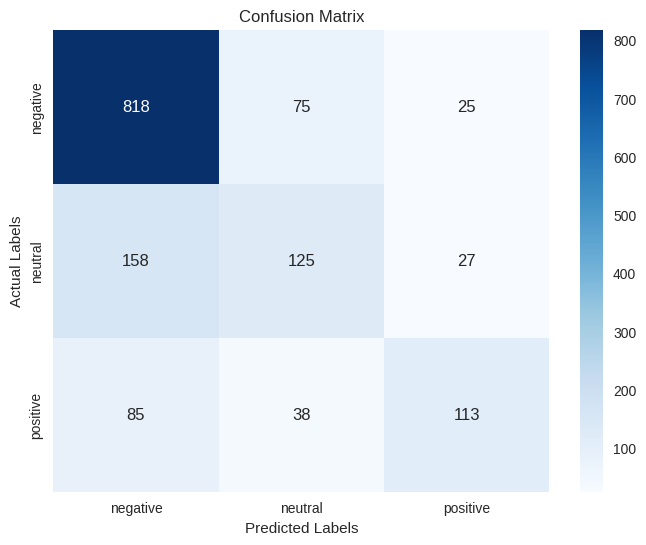

AUC (One-vs-Rest) on test data: 0.8393
f1-score on test data: 0.7058


In [12]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_processed, y_train_processed)

y_train_pred = clf.predict(X_train_processed)
train_accuracy = accuracy_score(y_train_processed, y_train_pred)
print(f"Accuracy on training data: {train_accuracy:.4f}")

y_test_pred = clf.predict(X_test_processed)
test_accuracy = accuracy_score(y_test_processed, y_test_pred)
print(f"Accuracy on test data: {test_accuracy:.4f}")
print("\nClassification report for the test data:")
print(classification_report(y_test_processed, y_test_pred, target_names=le.classes_))

cm = confusion_matrix(y_test_processed, y_test_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

y_test_prob = clf.predict_proba(X_test_processed)

auc = roc_auc_score(y_test_processed, y_test_prob, multi_class='ovr')
print(f"AUC (One-vs-Rest) on test data: {auc:.4f}")

test_f1 = f1_score(y_test_processed, y_test_pred, average='weighted')
print(f"f1-score on test data: {test_f1:.4f}")

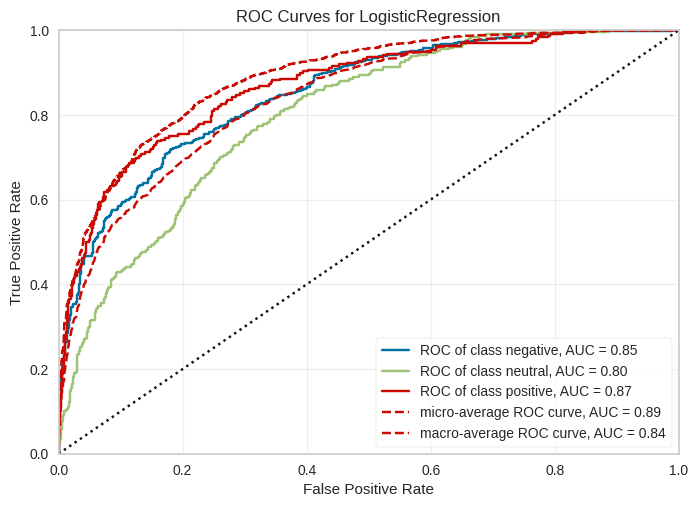

<Axes: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [13]:
visualizer = ROCAUC(
    clf,
    classes=le.classes_,
    cmap='prism',
    linewidth=1.5
)

visualizer.fit(X_train_processed, y_train_processed)
visualizer.score(X_test_processed, y_test_processed)

plt.title("ROC Curves with Distinct Colors")
plt.grid(alpha=0.3)
visualizer.show()

### XGBoost

In [14]:
clf = XGBClassifier(n_estimators=100)
clf.fit(X_train_processed, y_train_processed)


y_train_pred = clf.predict(X_train_processed)
train_acc = np.mean(y_train_pred == y_train_processed)
print(f'Train set accuracy: {train_acc}')

y_test_pred = clf.predict(X_test_processed)
test_acc = np.mean(y_test_pred == y_test_processed)
print(f'Test set accuracy: {test_accuracy}')

Train set accuracy: 0.8287037037037037
Test set accuracy: 0.7213114754098361


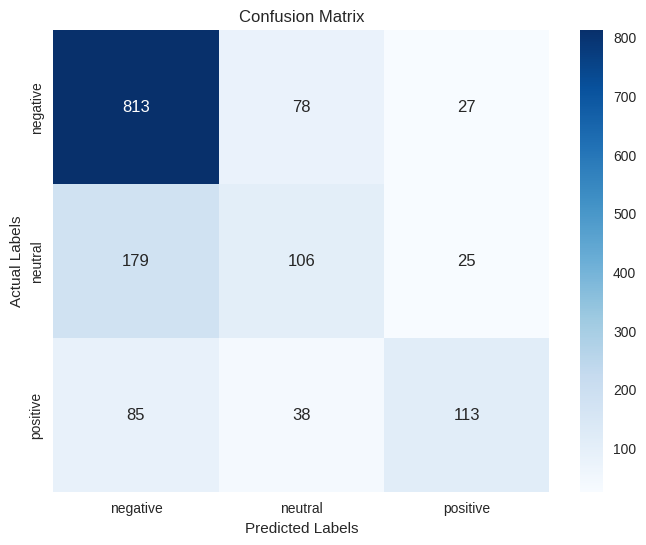

              precision    recall  f1-score   support

    negative       0.75      0.89      0.82       918
     neutral       0.48      0.34      0.40       310
    positive       0.68      0.48      0.56       236

    accuracy                           0.70      1464
   macro avg       0.64      0.57      0.59      1464
weighted avg       0.68      0.70      0.69      1464

AUC (One-vs-Rest) on test data: 0.8337
f1-score on test data: 0.6863


In [15]:
cm = confusion_matrix(y_test_processed, y_test_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()


y_test_prob = clf.predict_proba(X_test_processed)

print(classification_report(y_test_processed, y_test_pred, target_names=le.classes_))

auc = roc_auc_score(y_test_processed, y_test_prob, multi_class='ovr')
print(f"AUC (One-vs-Rest) on test data: {auc:.4f}")

test_f1 = f1_score(y_test_processed, y_test_pred, average='weighted')
print(f"f1-score on test data: {test_f1:.4f}")

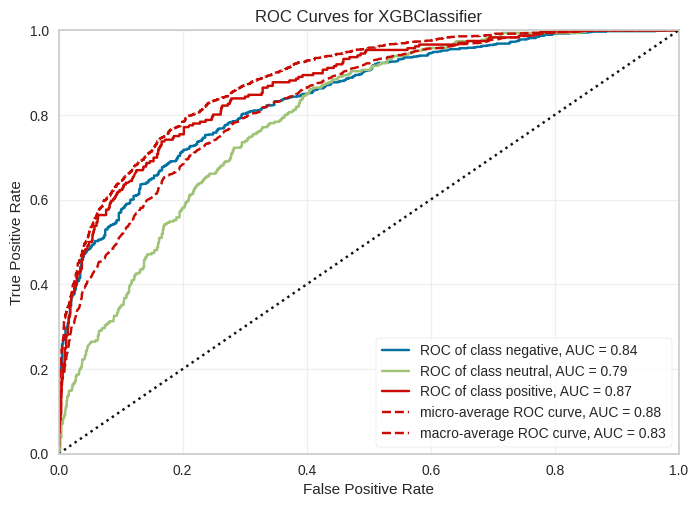

<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [16]:
visualizer = ROCAUC(
    clf,
    classes=le.classes_,
    colors='prism',
    linewidth=1.5
)

visualizer.fit(X_train_processed, y_train_processed)
visualizer.score(X_test_processed, y_test_processed)

plt.title("ROC Curves with Distinct Colors")
plt.grid(alpha=0.3)
visualizer.show()

### Neural Network

In [17]:
X_train_processed_t = torch.tensor(X_train_processed.toarray(), dtype=torch.float32)
X_test_processed_t = torch.tensor(X_test_processed.toarray(), dtype=torch.float32)

ohe = OneHotEncoder(sparse_output=False)
y_train_ohe = torch.tensor(ohe.fit_transform(y_train), dtype=torch.float32)
y_test_ohe = torch.tensor(ohe.transform(y_test), dtype=torch.float32)

le = LabelEncoder()
y_train_labels = le.fit_transform(y_train.values.flatten())
y_test_labels = le.transform(y_test.values.flatten())

In [18]:
class FNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fnn = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, output_dim),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float)
        x = self.fnn(x)
        return x

In [19]:
path = './results'
model_path = os.path.join(path, 'best_model.pt')
def fit_neural_network(
        model, optimizer, criterion,
        X: npt.NDArray, y: npt.NDArray,
        epochs: int, batch_size: int
    ):
    
    n_batches = np.ceil(len(X) / batch_size).astype(np.int32)
    max_acc = 0.0
    for epoch in range(epochs):
        model.train()
        print(f"epoch {epoch+1}/{epochs}")
        permutation_idx = torch.randperm(X.size(0))
        X_shuffled = X[permutation_idx]
        y_shuffled = y[permutation_idx]

        running_loss = 0.0
        for i in range(0, X.size(0), batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        model.eval()
        with torch.no_grad():
            y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
            f1s = f1_score(y_test_labels, y_pred, average='weighted')
            acc = accuracy_score(y_test_labels, y_pred)
            print(f"f1: {f1s:.3f}\tacc: {acc:.3f}")
            if acc > max_acc:
                max_acc = acc
                # if os.path.exists(model_path):
                    # print('exists')
                    # os.remove(model_path)
                # if error with pickle happens here, upgrade to python 3.13
                torch.save(model, model_path)
            running_loss = 0

In [20]:
model = FNN(X_train_processed_t.shape[1], 3)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [21]:
fit_neural_network(model, optimizer, criterion, X_train_processed_t, y_train_ohe, epochs=500, batch_size=128)

epoch 1/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.490	acc: 0.620
epoch 2/500
f1: 0.483	acc: 0.627
epoch 3/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.483	acc: 0.627
epoch 4/500
f1: 0.483	acc: 0.627
epoch 5/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.483	acc: 0.627
epoch 6/500
f1: 0.483	acc: 0.627
epoch 7/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.483	acc: 0.627
epoch 8/500
f1: 0.483	acc: 0.627
epoch 9/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.483	acc: 0.627
epoch 10/500
f1: 0.483	acc: 0.627
epoch 11/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.491	acc: 0.630
epoch 12/500
f1: 0.512	acc: 0.639
epoch 13/500
f1: 0.540	acc: 0.652
epoch 14/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.568	acc: 0.668
epoch 15/500
f1: 0.577	acc: 0.672
epoch 16/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.588	acc: 0.676
epoch 17/500
f1: 0.590	acc: 0.677
epoch 18/500
f1: 0.591	acc: 0.676
epoch 19/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.592	acc: 0.678
epoch 20/500
f1: 0.591	acc: 0.674
epoch 21/500
f1: 0.593	acc: 0.680
epoch 22/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.595	acc: 0.678
epoch 23/500
f1: 0.595	acc: 0.680
epoch 24/500
f1: 0.601	acc: 0.682
epoch 25/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.616	acc: 0.689
epoch 26/500
f1: 0.642	acc: 0.699
epoch 27/500
f1: 0.655	acc: 0.704
epoch 28/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.663	acc: 0.707
epoch 29/500
f1: 0.673	acc: 0.712
epoch 30/500
f1: 0.681	acc: 0.717
epoch 31/500
f1: 0.687	acc: 0.719
epoch 32/500
f1: 0.690	acc: 0.718
epoch 33/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.692	acc: 0.721
epoch 34/500
f1: 0.695	acc: 0.722
epoch 35/500
f1: 0.696	acc: 0.721
epoch 36/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.698	acc: 0.723
epoch 37/500
f1: 0.700	acc: 0.723
epoch 38/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.701	acc: 0.723
epoch 39/500
f1: 0.701	acc: 0.725
epoch 40/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.707	acc: 0.727
epoch 41/500
f1: 0.706	acc: 0.726
epoch 42/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.707	acc: 0.727
epoch 43/500
f1: 0.710	acc: 0.728
epoch 44/500
f1: 0.710	acc: 0.727
epoch 45/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.712	acc: 0.728
epoch 46/500
f1: 0.710	acc: 0.727
epoch 47/500
f1: 0.708	acc: 0.727
epoch 48/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.709	acc: 0.727
epoch 49/500
f1: 0.708	acc: 0.725
epoch 50/500
f1: 0.708	acc: 0.725
epoch 51/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.710	acc: 0.727
epoch 52/500
f1: 0.711	acc: 0.730
epoch 53/500
f1: 0.709	acc: 0.726
epoch 54/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.711	acc: 0.730
epoch 55/500
f1: 0.710	acc: 0.726
epoch 56/500
f1: 0.711	acc: 0.728
epoch 57/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.726
epoch 58/500
f1: 0.715	acc: 0.730
epoch 59/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.717	acc: 0.730
epoch 60/500
f1: 0.715	acc: 0.730
epoch 61/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.727
epoch 62/500
f1: 0.715	acc: 0.728
epoch 63/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.728
epoch 64/500
f1: 0.711	acc: 0.727
epoch 65/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.714	acc: 0.728
epoch 66/500
f1: 0.714	acc: 0.727
epoch 67/500
f1: 0.713	acc: 0.728
epoch 68/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.713	acc: 0.727
epoch 69/500
f1: 0.714	acc: 0.726
epoch 70/500
f1: 0.712	acc: 0.725
epoch 71/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.713	acc: 0.724
epoch 72/500
f1: 0.712	acc: 0.725
epoch 73/500
f1: 0.712	acc: 0.727
epoch 74/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.713	acc: 0.726
epoch 75/500
f1: 0.714	acc: 0.727
epoch 76/500
f1: 0.713	acc: 0.725
epoch 77/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.714	acc: 0.727
epoch 78/500
f1: 0.712	acc: 0.725
epoch 79/500
f1: 0.713	acc: 0.727
epoch 80/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.714	acc: 0.725
epoch 81/500
f1: 0.713	acc: 0.726
epoch 82/500
f1: 0.712	acc: 0.721
epoch 83/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.713	acc: 0.727
epoch 84/500
f1: 0.714	acc: 0.725
epoch 85/500
f1: 0.712	acc: 0.725
epoch 86/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.718	acc: 0.730
epoch 87/500
f1: 0.718	acc: 0.729
epoch 88/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.715	acc: 0.729
epoch 89/500
f1: 0.715	acc: 0.723
epoch 90/500
f1: 0.714	acc: 0.726
epoch 91/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.714	acc: 0.728
epoch 92/500
f1: 0.716	acc: 0.727
epoch 93/500
f1: 0.714	acc: 0.724
epoch 94/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.716	acc: 0.727
epoch 95/500
f1: 0.716	acc: 0.727
epoch 96/500
f1: 0.713	acc: 0.723
epoch 97/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.713	acc: 0.723
epoch 98/500
f1: 0.715	acc: 0.725
epoch 99/500
f1: 0.715	acc: 0.725
epoch 100/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.717	acc: 0.729
epoch 101/500
f1: 0.717	acc: 0.725
epoch 102/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.716	acc: 0.726
epoch 103/500
f1: 0.719	acc: 0.729
epoch 104/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.717	acc: 0.727
epoch 105/500
f1: 0.717	acc: 0.728
epoch 106/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.726
epoch 107/500
f1: 0.714	acc: 0.723
epoch 108/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.713	acc: 0.722
epoch 109/500
f1: 0.715	acc: 0.725
epoch 110/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.717	acc: 0.728
epoch 111/500
f1: 0.717	acc: 0.727
epoch 112/500
f1: 0.714	acc: 0.723
epoch 113/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.714	acc: 0.724
epoch 114/500
f1: 0.717	acc: 0.727
epoch 115/500
f1: 0.715	acc: 0.725
epoch 116/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.716	acc: 0.725
epoch 117/500
f1: 0.714	acc: 0.723
epoch 118/500
f1: 0.716	acc: 0.725
epoch 119/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.713	acc: 0.723
epoch 120/500
f1: 0.714	acc: 0.723
epoch 121/500
f1: 0.714	acc: 0.723
epoch 122/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.714	acc: 0.723
epoch 123/500
f1: 0.713	acc: 0.722
epoch 124/500
f1: 0.713	acc: 0.723
epoch 125/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.713	acc: 0.722
epoch 126/500
f1: 0.713	acc: 0.722
epoch 127/500
f1: 0.713	acc: 0.721
epoch 128/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.715	acc: 0.725
epoch 129/500
f1: 0.712	acc: 0.721
epoch 130/500
f1: 0.713	acc: 0.722
epoch 131/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.722
epoch 132/500
f1: 0.714	acc: 0.723
epoch 133/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.724
epoch 134/500
f1: 0.715	acc: 0.725
epoch 135/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.715	acc: 0.726
epoch 136/500
f1: 0.715	acc: 0.722
epoch 137/500
f1: 0.712	acc: 0.721
epoch 138/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.715	acc: 0.724
epoch 139/500
f1: 0.715	acc: 0.723
epoch 140/500
f1: 0.716	acc: 0.725
epoch 141/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.716	acc: 0.724
epoch 142/500
f1: 0.716	acc: 0.725
epoch 143/500
f1: 0.714	acc: 0.724
epoch 144/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.725
epoch 145/500
f1: 0.715	acc: 0.725
epoch 146/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.715	acc: 0.725
epoch 147/500
f1: 0.714	acc: 0.723
epoch 148/500
f1: 0.716	acc: 0.726
epoch 149/500
f1: 0.717	acc: 0.727
epoch 150/500
f1: 0.712	acc: 0.721
epoch 151/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.719	acc: 0.730
epoch 152/500
f1: 0.714	acc: 0.723
epoch 153/500
f1: 0.718	acc: 0.729
epoch 154/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.717	acc: 0.726
epoch 155/500
f1: 0.718	acc: 0.728
epoch 156/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.718	acc: 0.730
epoch 157/500
f1: 0.719	acc: 0.730
epoch 158/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.716	acc: 0.725
epoch 159/500
f1: 0.716	acc: 0.725
epoch 160/500
f1: 0.719	acc: 0.728
epoch 161/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.716	acc: 0.725
epoch 162/500
f1: 0.719	acc: 0.730
epoch 163/500
f1: 0.720	acc: 0.730
epoch 164/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.716	acc: 0.725
epoch 165/500
f1: 0.717	acc: 0.728
epoch 166/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.720	acc: 0.730
epoch 167/500
f1: 0.715	acc: 0.725
epoch 168/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.716	acc: 0.725
epoch 169/500
f1: 0.718	acc: 0.727
epoch 170/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.717	acc: 0.726
epoch 171/500
f1: 0.717	acc: 0.728
epoch 172/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.716	acc: 0.727
epoch 173/500
f1: 0.717	acc: 0.727
epoch 174/500
f1: 0.718	acc: 0.727
epoch 175/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.717	acc: 0.726
epoch 176/500
f1: 0.715	acc: 0.725
epoch 177/500
f1: 0.717	acc: 0.728
epoch 178/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.716	acc: 0.725
epoch 179/500
f1: 0.717	acc: 0.727
epoch 180/500
f1: 0.718	acc: 0.729
epoch 181/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.717	acc: 0.726
epoch 182/500
f1: 0.716	acc: 0.727
epoch 183/500
f1: 0.715	acc: 0.726
epoch 184/500
f1: 0.718	acc: 0.730
epoch 185/500
f1: 0.717	acc: 0.728
epoch 186/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.718	acc: 0.730
epoch 187/500
f1: 0.715	acc: 0.725
epoch 188/500
f1: 0.713	acc: 0.723
epoch 189/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.716	acc: 0.726
epoch 190/500
f1: 0.715	acc: 0.725
epoch 191/500
f1: 0.715	acc: 0.724
epoch 192/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.717	acc: 0.727
epoch 193/500
f1: 0.714	acc: 0.723
epoch 194/500
f1: 0.713	acc: 0.723
epoch 195/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.716	acc: 0.725
epoch 196/500
f1: 0.715	acc: 0.724
epoch 197/500
f1: 0.719	acc: 0.731
epoch 198/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.718	acc: 0.728
epoch 199/500
f1: 0.716	acc: 0.727
epoch 200/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.717	acc: 0.728
epoch 201/500
f1: 0.714	acc: 0.723
epoch 202/500
f1: 0.715	acc: 0.724
epoch 203/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.719	acc: 0.730
epoch 204/500
f1: 0.719	acc: 0.730
epoch 205/500
f1: 0.717	acc: 0.727
epoch 206/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.720	acc: 0.731
epoch 207/500
f1: 0.717	acc: 0.728
epoch 208/500
f1: 0.716	acc: 0.727
epoch 209/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.718	acc: 0.730
epoch 210/500
f1: 0.718	acc: 0.730
epoch 211/500
f1: 0.719	acc: 0.730
epoch 212/500
f1: 0.716	acc: 0.727
epoch 213/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.718	acc: 0.729
epoch 214/500
f1: 0.718	acc: 0.730
epoch 215/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.718	acc: 0.728
epoch 216/500
f1: 0.717	acc: 0.726
epoch 217/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.718	acc: 0.727
epoch 218/500
f1: 0.720	acc: 0.731
epoch 219/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.719	acc: 0.730
epoch 220/500
f1: 0.722	acc: 0.734
epoch 221/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.718	acc: 0.730
epoch 222/500
f1: 0.718	acc: 0.728
epoch 223/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.721	acc: 0.732
epoch 224/500
f1: 0.720	acc: 0.731
epoch 225/500
f1: 0.716	acc: 0.726
epoch 226/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.718	acc: 0.728
epoch 227/500
f1: 0.719	acc: 0.730
epoch 228/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.717	acc: 0.728
epoch 229/500
f1: 0.718	acc: 0.728
epoch 230/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.721	acc: 0.734
epoch 231/500
f1: 0.718	acc: 0.730
epoch 232/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.723
epoch 233/500
f1: 0.716	acc: 0.726
epoch 234/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.714	acc: 0.725
epoch 235/500
f1: 0.718	acc: 0.729
epoch 236/500
f1: 0.720	acc: 0.731
epoch 237/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.716	acc: 0.726
epoch 238/500
f1: 0.717	acc: 0.728
epoch 239/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.719	acc: 0.730
epoch 240/500
f1: 0.715	acc: 0.726
epoch 241/500
f1: 0.717	acc: 0.728
epoch 242/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.718	acc: 0.728
epoch 243/500
f1: 0.719	acc: 0.730
epoch 244/500
f1: 0.716	acc: 0.726
epoch 245/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.715	acc: 0.726
epoch 246/500
f1: 0.715	acc: 0.726
epoch 247/500
f1: 0.716	acc: 0.726
epoch 248/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.727
epoch 249/500
f1: 0.713	acc: 0.724
epoch 250/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.716	acc: 0.728
epoch 251/500
f1: 0.717	acc: 0.728
epoch 252/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.725
epoch 253/500
f1: 0.715	acc: 0.727
epoch 254/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.716	acc: 0.726
epoch 255/500
f1: 0.714	acc: 0.725
epoch 256/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.724
epoch 257/500
f1: 0.715	acc: 0.725
epoch 258/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.716	acc: 0.727
epoch 259/500
f1: 0.718	acc: 0.730
epoch 260/500
f1: 0.713	acc: 0.725
epoch 261/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.727
epoch 262/500
f1: 0.714	acc: 0.725
epoch 263/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.716	acc: 0.725
epoch 264/500
f1: 0.715	acc: 0.725
epoch 265/500
f1: 0.716	acc: 0.727
epoch 266/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.725
epoch 267/500
f1: 0.715	acc: 0.726
epoch 268/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.727
epoch 269/500
f1: 0.714	acc: 0.725
epoch 270/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.717	acc: 0.727
epoch 271/500
f1: 0.715	acc: 0.725
epoch 272/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.717	acc: 0.727
epoch 273/500
f1: 0.717	acc: 0.728
epoch 274/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.716	acc: 0.727
epoch 275/500
f1: 0.714	acc: 0.725
epoch 276/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.718	acc: 0.731
epoch 277/500
f1: 0.714	acc: 0.725
epoch 278/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.713	acc: 0.724
epoch 279/500
f1: 0.720	acc: 0.730
epoch 280/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.718	acc: 0.730
epoch 281/500
f1: 0.719	acc: 0.729
epoch 282/500
f1: 0.715	acc: 0.727
epoch 283/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.716	acc: 0.727
epoch 284/500
f1: 0.714	acc: 0.725
epoch 285/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.714	acc: 0.725
epoch 286/500
f1: 0.717	acc: 0.728
epoch 287/500
f1: 0.717	acc: 0.730
epoch 288/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.714	acc: 0.725
epoch 289/500
f1: 0.716	acc: 0.727
epoch 290/500
f1: 0.717	acc: 0.729
epoch 291/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.716	acc: 0.727
epoch 292/500
f1: 0.719	acc: 0.730
epoch 293/500
f1: 0.718	acc: 0.730
epoch 294/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.716	acc: 0.727
epoch 295/500
f1: 0.715	acc: 0.726
epoch 296/500
f1: 0.717	acc: 0.731
epoch 297/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.719	acc: 0.730
epoch 298/500
f1: 0.718	acc: 0.730
epoch 299/500
f1: 0.717	acc: 0.728
epoch 300/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.717	acc: 0.728
epoch 301/500
f1: 0.718	acc: 0.729
epoch 302/500
f1: 0.716	acc: 0.727
epoch 303/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.717	acc: 0.727
epoch 304/500
f1: 0.719	acc: 0.730
epoch 305/500
f1: 0.716	acc: 0.727
epoch 306/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.715	acc: 0.727
epoch 307/500
f1: 0.720	acc: 0.730
epoch 308/500
f1: 0.717	acc: 0.730
epoch 309/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.720	acc: 0.731
epoch 310/500
f1: 0.716	acc: 0.727
epoch 311/500
f1: 0.717	acc: 0.729
epoch 312/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.716	acc: 0.727
epoch 313/500
f1: 0.722	acc: 0.733
epoch 314/500
f1: 0.720	acc: 0.731
epoch 315/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.721	acc: 0.732
epoch 316/500
f1: 0.718	acc: 0.728
epoch 317/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.718	acc: 0.730
epoch 318/500
f1: 0.723	acc: 0.734
epoch 319/500
f1: 0.720	acc: 0.732
epoch 320/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.720	acc: 0.731
epoch 321/500
f1: 0.719	acc: 0.730
epoch 322/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.721	acc: 0.732
epoch 323/500
f1: 0.721	acc: 0.732
epoch 324/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.716	acc: 0.729
epoch 325/500
f1: 0.720	acc: 0.731
epoch 326/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.722	acc: 0.732
epoch 327/500
f1: 0.721	acc: 0.732
epoch 328/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.717	acc: 0.730
epoch 329/500
f1: 0.721	acc: 0.732
epoch 330/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.722	acc: 0.733
epoch 331/500
f1: 0.720	acc: 0.731
epoch 332/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.721	acc: 0.732
epoch 333/500
f1: 0.720	acc: 0.730
epoch 334/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.720	acc: 0.732
epoch 335/500
f1: 0.720	acc: 0.731
epoch 336/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.722	acc: 0.732
epoch 337/500
f1: 0.716	acc: 0.728
epoch 338/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.720	acc: 0.731
epoch 339/500
f1: 0.721	acc: 0.732
epoch 340/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.720	acc: 0.730
epoch 341/500
f1: 0.721	acc: 0.731
epoch 342/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.720	acc: 0.731
epoch 343/500
f1: 0.721	acc: 0.732
epoch 344/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.723	acc: 0.734
epoch 345/500
f1: 0.721	acc: 0.732
epoch 346/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.720	acc: 0.731
epoch 347/500
f1: 0.719	acc: 0.730
epoch 348/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.719	acc: 0.732
epoch 349/500
f1: 0.719	acc: 0.730
epoch 350/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.719	acc: 0.730
epoch 351/500
f1: 0.721	acc: 0.732
epoch 352/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.717	acc: 0.729
epoch 353/500
f1: 0.719	acc: 0.730
epoch 354/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.717	acc: 0.729
epoch 355/500
f1: 0.718	acc: 0.730
epoch 356/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.727
epoch 357/500
f1: 0.719	acc: 0.728
epoch 358/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.717	acc: 0.730
epoch 359/500
f1: 0.719	acc: 0.730
epoch 360/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.720	acc: 0.731
epoch 361/500
f1: 0.717	acc: 0.728
epoch 362/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.717	acc: 0.728
epoch 363/500
f1: 0.716	acc: 0.727
epoch 364/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.716	acc: 0.728
epoch 365/500
f1: 0.715	acc: 0.727
epoch 366/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.718	acc: 0.730
epoch 367/500
f1: 0.720	acc: 0.730
epoch 368/500
f1: 0.720	acc: 0.730
epoch 369/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.720	acc: 0.731
epoch 370/500
f1: 0.719	acc: 0.730
epoch 371/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.718	acc: 0.730
epoch 372/500
f1: 0.718	acc: 0.730
epoch 373/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.720	acc: 0.731
epoch 374/500
f1: 0.717	acc: 0.728
epoch 375/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.718	acc: 0.729
epoch 376/500
f1: 0.719	acc: 0.730
epoch 377/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.720	acc: 0.732
epoch 378/500
f1: 0.718	acc: 0.730
epoch 379/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.718	acc: 0.730
epoch 380/500
f1: 0.716	acc: 0.728
epoch 381/500
f1: 0.716	acc: 0.727
epoch 382/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.716	acc: 0.727
epoch 383/500
f1: 0.718	acc: 0.729
epoch 384/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.717	acc: 0.730
epoch 385/500
f1: 0.719	acc: 0.730
epoch 386/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.721	acc: 0.732
epoch 387/500
f1: 0.718	acc: 0.728
epoch 388/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.719	acc: 0.730
epoch 389/500
f1: 0.718	acc: 0.730
epoch 390/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.718	acc: 0.730
epoch 391/500
f1: 0.718	acc: 0.728
epoch 392/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.717	acc: 0.728
epoch 393/500
f1: 0.714	acc: 0.727
epoch 394/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.718	acc: 0.728
epoch 395/500
f1: 0.716	acc: 0.727
epoch 396/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.717	acc: 0.730
epoch 397/500
f1: 0.716	acc: 0.727
epoch 398/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.716	acc: 0.728
epoch 399/500
f1: 0.717	acc: 0.728
epoch 400/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.727
epoch 401/500
f1: 0.718	acc: 0.730
epoch 402/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.718	acc: 0.730
epoch 403/500
f1: 0.719	acc: 0.730
epoch 404/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.714	acc: 0.727
epoch 405/500
f1: 0.716	acc: 0.728
epoch 406/500
f1: 0.717	acc: 0.728
epoch 407/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.714	acc: 0.727
epoch 408/500
f1: 0.714	acc: 0.727
epoch 409/500
f1: 0.717	acc: 0.728
epoch 410/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.715	acc: 0.727
epoch 411/500
f1: 0.716	acc: 0.727
epoch 412/500
f1: 0.716	acc: 0.727
epoch 413/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.717	acc: 0.730
epoch 414/500
f1: 0.715	acc: 0.727
epoch 415/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.725
epoch 416/500
f1: 0.716	acc: 0.727
epoch 417/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.717	acc: 0.730
epoch 418/500
f1: 0.716	acc: 0.727
epoch 419/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.727
epoch 420/500
f1: 0.715	acc: 0.727
epoch 421/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.727
epoch 422/500
f1: 0.715	acc: 0.727
epoch 423/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.727
epoch 424/500
f1: 0.716	acc: 0.728
epoch 425/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.717	acc: 0.729
epoch 426/500
f1: 0.717	acc: 0.728
epoch 427/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.726
epoch 428/500
f1: 0.719	acc: 0.732
epoch 429/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.727
epoch 430/500
f1: 0.717	acc: 0.729
epoch 431/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.717	acc: 0.730
epoch 432/500
f1: 0.716	acc: 0.728
epoch 433/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.715	acc: 0.726
epoch 434/500
f1: 0.715	acc: 0.727
epoch 435/500
f1: 0.716	acc: 0.728
epoch 436/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.727
epoch 437/500
f1: 0.716	acc: 0.728
epoch 438/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.717	acc: 0.728
epoch 439/500
f1: 0.715	acc: 0.727
epoch 440/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.716	acc: 0.727
epoch 441/500
f1: 0.717	acc: 0.730
epoch 442/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.718	acc: 0.730
epoch 443/500
f1: 0.716	acc: 0.729
epoch 444/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.717	acc: 0.729
epoch 445/500
f1: 0.716	acc: 0.727
epoch 446/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.717	acc: 0.730
epoch 447/500
f1: 0.717	acc: 0.728
epoch 448/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.717	acc: 0.729
epoch 449/500
f1: 0.716	acc: 0.727
epoch 450/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.713	acc: 0.725
epoch 451/500
f1: 0.716	acc: 0.727
epoch 452/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.726
epoch 453/500
f1: 0.714	acc: 0.726
epoch 454/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.727
epoch 455/500
f1: 0.714	acc: 0.727
epoch 456/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.727
epoch 457/500
f1: 0.715	acc: 0.727
epoch 458/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.713	acc: 0.726
epoch 459/500
f1: 0.716	acc: 0.729
epoch 460/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.727
epoch 461/500
f1: 0.716	acc: 0.728
epoch 462/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.716	acc: 0.727
epoch 463/500
f1: 0.716	acc: 0.728
epoch 464/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.717	acc: 0.728
epoch 465/500
f1: 0.714	acc: 0.727
epoch 466/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.716	acc: 0.728
epoch 467/500
f1: 0.716	acc: 0.727
epoch 468/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.727
epoch 469/500
f1: 0.712	acc: 0.725
epoch 470/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.726
epoch 471/500
f1: 0.717	acc: 0.729
epoch 472/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.716	acc: 0.727
epoch 473/500
f1: 0.716	acc: 0.727
epoch 474/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.726
epoch 475/500
f1: 0.714	acc: 0.726
epoch 476/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.726
epoch 477/500
f1: 0.714	acc: 0.725
epoch 478/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.727
epoch 479/500
f1: 0.716	acc: 0.728
epoch 480/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.717	acc: 0.729
epoch 481/500
f1: 0.714	acc: 0.726
epoch 482/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.727
epoch 483/500
f1: 0.716	acc: 0.727
epoch 484/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.727
epoch 485/500
f1: 0.715	acc: 0.726
epoch 486/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.727
epoch 487/500
f1: 0.713	acc: 0.726
epoch 488/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.713	acc: 0.725
epoch 489/500
f1: 0.715	acc: 0.727
epoch 490/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.713	acc: 0.726
epoch 491/500
f1: 0.714	acc: 0.726
epoch 492/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.725
epoch 493/500
f1: 0.716	acc: 0.727
epoch 494/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.726
epoch 495/500
f1: 0.714	acc: 0.727
epoch 496/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.726
epoch 497/500
f1: 0.716	acc: 0.728
epoch 498/500


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.716	acc: 0.728
epoch 499/500
f1: 0.716	acc: 0.729
epoch 500/500
f1: 0.716	acc: 0.727


/tmp/ipykernel_33213/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


In [22]:
model = torch.load(model_path, weights_only=False)
model.eval()
y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
nn_acc = accuracy_score(y_test_labels, y_pred)
nn_f1 = f1_score(y_test_labels, y_pred, average='weighted')
print(f'Neural Network Accuracy: {nn_acc}')
print(f'Neural Network F1-score: {nn_f1}')

Neural Network Accuracy: 0.7336065573770492
Neural Network F1-score: 0.7215001446444537


/tmp/ipykernel_33213/2170323652.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


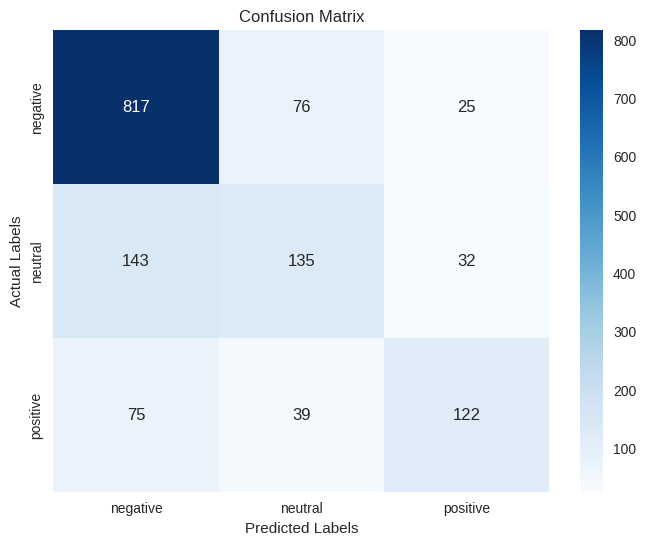

In [23]:
cm = confusion_matrix(y_test_labels, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

/tmp/ipykernel_33213/231785274.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_train_pred = np.array(torch.argmax(y_train_pred, dim=1))
/tmp/ipykernel_33213/231785274.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_test_pred = np.array(torch.argmax(y_test_pred, dim=1))


Accuracy on training data: 0.8130
Accuracy on test data: 0.7336

Classification report for the test data:
              precision    recall  f1-score   support

    negative       0.79      0.89      0.84       918
     neutral       0.54      0.44      0.48       310
    positive       0.68      0.52      0.59       236

    accuracy                           0.73      1464
   macro avg       0.67      0.61      0.64      1464
weighted avg       0.72      0.73      0.72      1464



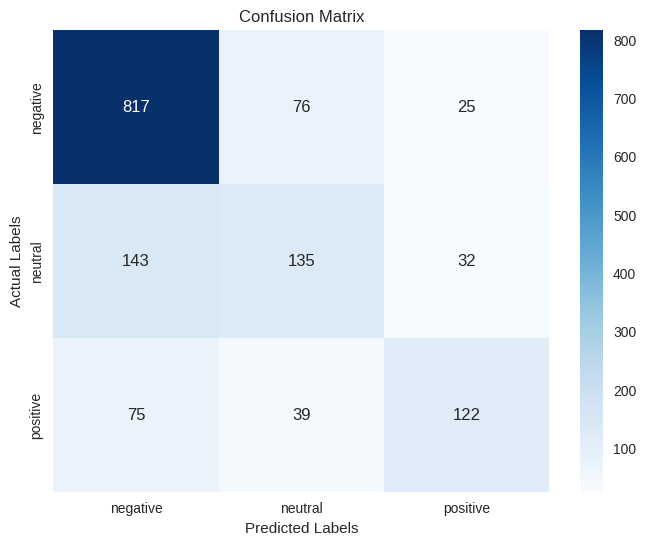

In [24]:
y_train_pred = model(X_train_processed_t)
y_train_pred = np.array(torch.argmax(y_train_pred, dim=1))

train_accuracy = accuracy_score(y_train_labels, y_train_pred)
print(f"Accuracy on training data: {train_accuracy:.4f}")

y_test_pred = model(X_test_processed_t)
y_test_pred = np.array(torch.argmax(y_test_pred, dim=1))
test_accuracy = accuracy_score(y_test_labels, y_test_pred)
print(f"Accuracy on test data: {test_accuracy:.4f}")
print("\nClassification report for the test data:")
print(classification_report(y_test_labels, y_test_pred, target_names=le.classes_))

cm = confusion_matrix(y_test_labels, y_test_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()


In [25]:
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_processed_t) 

y_pred_probs = y_pred_probs.cpu().numpy()  
num_classes = 3
y_test_onehot = label_binarize(y_test_labels, classes=[0, 1, 2])  
auc_ovr_weighted = roc_auc_score(y_test_onehot, y_pred_probs, multi_class="ovr", average="weighted")
print("Weighted One-vs-Rest AUC:", auc_ovr_weighted)

gini_ovr_weighted = 2 * auc_ovr_weighted - 1
print("Gini:", gini_ovr_weighted)

auc_per_class = roc_auc_score(y_test_onehot, y_pred_probs, multi_class="ovr", average=None)
gini_per_class = 2 * auc_per_class - 1
for i, (auc_val, gini_val) in enumerate(zip(auc_per_class, gini_per_class)):
    print(f"Class {i}: AUC={auc_val:.3f}, Gini={gini_val:.3f}")

Weighted One-vs-Rest AUC: 0.8268086120912365
Gini: 0.6536172241824729
Class 0: AUC=0.836, Gini=0.673
Class 1: AUC=0.778, Gini=0.555
Class 2: AUC=0.854, Gini=0.708


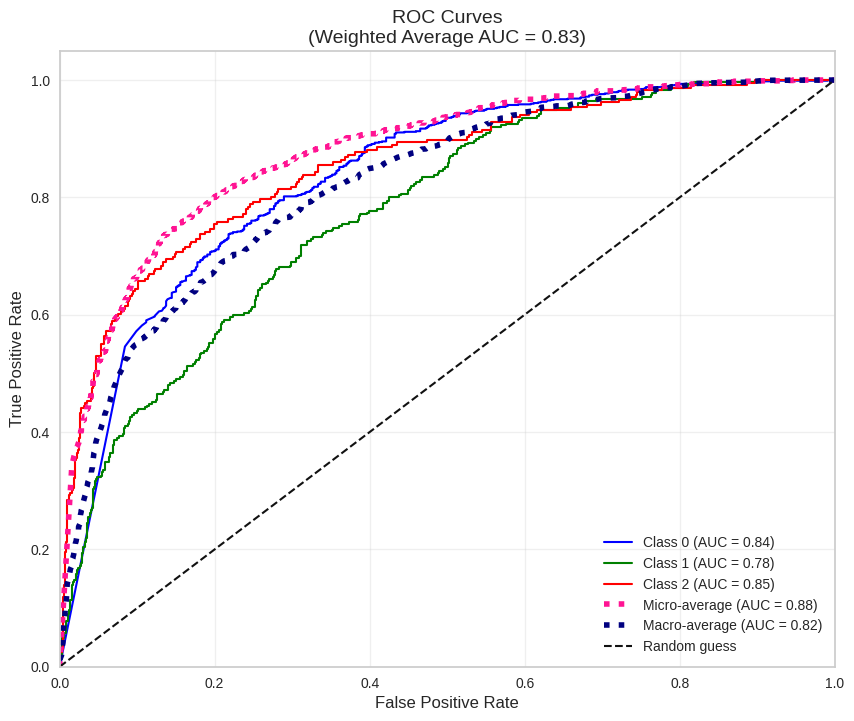

In [26]:
num_classes = 3

fpr = dict()
tpr = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred_probs[:, i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), y_pred_probs.ravel())
auc_micro = roc_auc_score(y_test_onehot, y_pred_probs, multi_class="ovr", average="micro")

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
auc_macro = roc_auc_score(y_test_onehot, y_pred_probs, multi_class="ovr", average="macro")

auc_ovr_weighted = roc_auc_score(y_test_onehot, y_pred_probs, multi_class="ovr", average="weighted")

plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red']

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label=f'Class {i} (AUC = {auc_per_class[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average (AUC = {auc_micro:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average (AUC = {auc_macro:.2f})',
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curves\n(Weighted Average AUC = {auc_ovr_weighted:.2f})', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.show()

In [27]:
del model

# Stage 4: Comparison with LLM Models (e.g., OpenAI)

**Goal**: Compare the results of custom-built models with those from LLM (Large Language Models).

**Tasks**:

1. **Developing an LLM Prompt**:
   - Create an effective prompt for sentiment analysis. Example:
     ```
     Analyze the sentiment of the following text and classify it as positive, negative, or neutral:
     "{text}"
     ```

2. **Using LLM API**:
   - Send test data to the LLM model via API.
   - Save LLM model predictions.
   - Ensure compliance with LLM usage policies.

3. **Analysis and Comparison of Results**:
   - Compare evaluation metrics of all models.
   - Identify differences in predictions between models.
   - Discuss potential reasons for these differences:
     - Ability to understand context.
     - Handling irony or sarcasm.
     - Impact of input data quality.

---

In [28]:
# Stage 4
import sys
!{sys.executable} -m pip install transformers
!{sys.executable} -m pip install transformers[sentencepiece]
!{sys.executable} -m pip install openai google-generativeai transformers torch seaborn

  Using cached sentencepiece-0.2.0.tar.gz (2.6 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [98 lines of output]
      /home/michal/miniconda3/envs/jup/lib/python3.13/site-packages/setuptools/_distutils/dist.py:270: UserWarning: Unknown distribution option: 'test_suite'
        warnings.warn(msg)
      running bdist_wheel
      running build
      running build_py
      creating build/lib.linux-x86_64-cpython-313/sentencepiece
      copying src/sentencepiece/__init__.py -> build/lib.linux-x86_64-cpython-313/sentencepiece
      copying src/sentencepiece/_version.py -> build/lib.linux-x86_64-cpython-313/sentencepiece
      copying src/sentencepiece/sentencepiece_model_pb2.py -> build/lib.linux-x86_64-cpython-313/sentencepiece
      copying src/sentencepiece/sentencepiece_pb2.py -> build/lib.linux-x86_64-cpython-313/sentencepiece
      running build_ext
      Package s

In [29]:
import openai
import google.generativeai as genai
from transformers import pipeline

import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, RocCurveDisplay  
import matplotlib.pyplot as plt

import seaborn as sns
from tqdm import tqdm

import src.prompt_llm as prompt_llm

/home/michal/miniconda3/envs/jup/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
openai_key = input("Enter your OpenAI API key (or press Enter to skip and load precomputed CSV): ")
gemini_key = input("Enter your Gemini API key (or press Enter to skip and load precomputed CSV): ")

if openai_key:
    openai.api_key = openai_key
    openai_client = openai.OpenAI(api_key=openai_key)

if gemini_key:
    genai.configure(api_key=gemini_key)
    gemini_model = genai.GenerativeModel('gemini-1.5-flash')

roberta_classifier = pipeline(
    "sentiment-analysis", 
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    top_k=None
)

deberta_classifier = pipeline(
    "zero-shot-classification",
    model="sileod/deberta-v3-base-tasksource-nli"
)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
Device set to use cuda:0


In [31]:
csv_name = 'results/model_comparison.csv'

if openai_key and gemini_key:
    results = []
    for i in tqdm(range(len(X_test))):
        # if i == 10:
            # break
        row = X_test.iloc[i]
        text = row['text']
        
        prompt = f"""Analyze the sentiment of this text. Respond ONLY with one word: positive, negative, or neutral. No punctuation. Text: {text}"""

        deberta_pred = deberta_classifier(text, ['positive', 'negative', 'neutral'])
        deberta_final = deberta_pred['labels'][np.argmax(deberta_pred['scores'])]
        deberta_probs = {
            'deberta_positive': deberta_pred['scores'][0],
            'deberta_negative': deberta_pred['scores'][1],
            'deberta_neutral': deberta_pred['scores'][2]
        }
        
        try: gpt_pred = prompt_llm.get_gpt_sentiment(openai_client, prompt)
        except: gpt_pred = "error"
        
        try: gemini_pred = prompt_llm.get_gemini_sentiment(gemini_model, prompt)
        except: gemini_pred = "error"
        
        roberta_pred = prompt_llm.get_roberta_sentiment(roberta_classifier, text)
        roberta_probs = {}
        roberta_preds = roberta_classifier(text)[0]
        for pred in roberta_preds:
            label = pred['label'].lower()
            roberta_probs[f'roberta_{label}'] = pred['score']
        
        results.append({
            'text': text,
            'deberta': deberta_final,
            'gpt': gpt_pred,
            'gemini': gemini_pred,
            'roberta': roberta_pred,
            'deberta_positive': deberta_probs['deberta_positive'],
            'deberta_negative': deberta_probs['deberta_negative'],
            'deberta_neutral': deberta_probs['deberta_neutral'],
            'roberta_positive': roberta_probs.get('roberta_positive', 0),
            'roberta_negative': roberta_probs.get('roberta_negative', 0),
            'roberta_neutral': roberta_probs.get('roberta_neutral', 0),
                })
        
    results_df = pd.DataFrame(results)
    results_df.to_csv(csv_name, index=False)
else:
    print("One or both of the API keys missing. Loading data from CSV...")
    results_df = pd.read_csv(csv_name)

print(results_df.head())

100%|██████████| 1464/1464 [23:27<00:00,  1.04it/s]

                                                text   deberta       gpt  \
0  @united at its worse. Can't figure how to pack...  negative  negative   
1  “@USAirways: @ch_mom Please reach out to our c...  negative   neutral   
2  @SouthwestAir Pres/CEO Gary Kelly at #TheRoFo ...  positive   neutral   
3  @USAirways its fine. \n\nJust wondering where ...   neutral  negative   
4  @USAirways trying 2 fly frm DCA to SRQ to visi...  negative  negative   

     gemini   roberta  deberta_positive  deberta_negative  deberta_neutral  \
0  negative  negative          0.870505          0.081026         0.048469   
1   neutral  negative          0.447852          0.425024         0.127123   
2   neutral   neutral          0.368076          0.316620         0.315304   
3  negative   neutral          0.522265          0.320916         0.156819   
4  negative  negative          0.660794          0.196728         0.142477   

   roberta_positive  roberta_negative  roberta_neutral  
0          0.0044

In [32]:
y_true = y_test
print(results_df['deberta'])
print("DeBERTa Report:")
print(classification_report(y_true, results_df['deberta']))

print("\nGPT-3.5 Report:")
print(classification_report(y_true, results_df['gpt']))

print("\nGemini Report:")
print(classification_report(y_true, results_df['gemini']))

print("\nRoberta Report:")
print(classification_report(y_true, results_df['roberta']))

0       negative
1       negative
2       positive
3        neutral
4       negative
          ...   
1459    negative
1460    negative
1461    positive
1462    positive
1463    negative
Name: deberta, Length: 1464, dtype: object
DeBERTa Report:
              precision    recall  f1-score   support

    negative       0.86      0.90      0.88       918
     neutral       0.55      0.07      0.12       310
    positive       0.48      0.94      0.64       236

    accuracy                           0.73      1464
   macro avg       0.63      0.64      0.55      1464
weighted avg       0.73      0.73      0.68      1464


GPT-3.5 Report:
              precision    recall  f1-score   support

    negative       0.94      0.86      0.90       918
     neutral       0.62      0.73      0.67       310
    positive       0.75      0.83      0.79       236

    accuracy                           0.83      1464
   macro avg       0.77      0.81      0.79      1464
weighted avg       0.84      0

/home/michal/miniconda3/envs/jup/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michal/miniconda3/envs/jup/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michal/miniconda3/envs/jup/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1400x800 with 0 Axes>

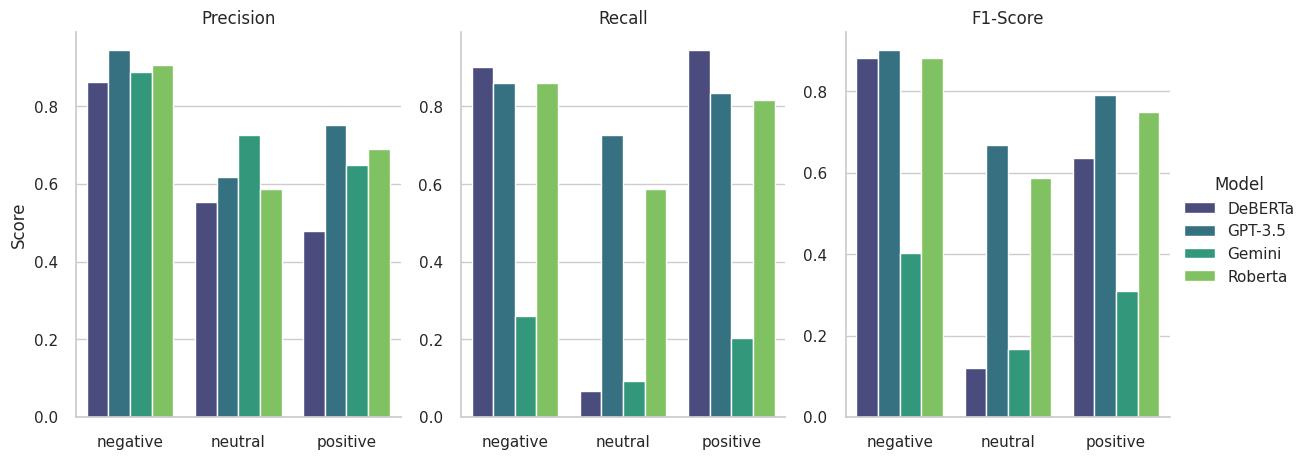

In [33]:
EXCLUDED_CLASSES = {'accuracy', 'macro avg', 'weighted avg', 'error', 'nostalgic', 'mixed'}

def get_report_dict(y_true, y_pred):
    return classification_report(y_true, y_pred, output_dict=True, zero_division=0)

reports = {
    'DeBERTa': get_report_dict(y_true, results_df['deberta']),
    'GPT-3.5': get_report_dict(y_true, results_df['gpt']),
    'Gemini': get_report_dict(y_true, results_df['gemini']),
    'Roberta': get_report_dict(y_true, results_df['roberta'])
}

metrics_data = []
for model_name, report in reports.items():
    for class_name, metrics in report.items():
        if class_name in ['accuracy', 'macro avg', 'weighted avg', 'error', 'nostalgic', 'mixed']:
            continue
        metrics_data.append({
            'Model': model_name,
            'Class': class_name,
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1-score'],
            'Support': metrics['support']
        })

df = pd.DataFrame(metrics_data)

plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

melted_df = df.melt(id_vars=['Model', 'Class'], 
                    value_vars=['Precision', 'Recall', 'F1-Score'],
                    var_name='Metric')

g = sns.catplot(
    data=melted_df,
    x='Class', y='value', hue='Model',
    col='Metric', kind='bar',
    height=5, aspect=0.8,
    palette='viridis',
    sharey=False
)

g.set_axis_labels("", "Score")
g.set_titles("{col_name}")
accuracy_data = {model: report['accuracy'] for model, report in reports.items()}
accuracy_df = pd.DataFrame([accuracy_data]).T.reset_index()
accuracy_df.columns = ['Model', 'Accuracy']


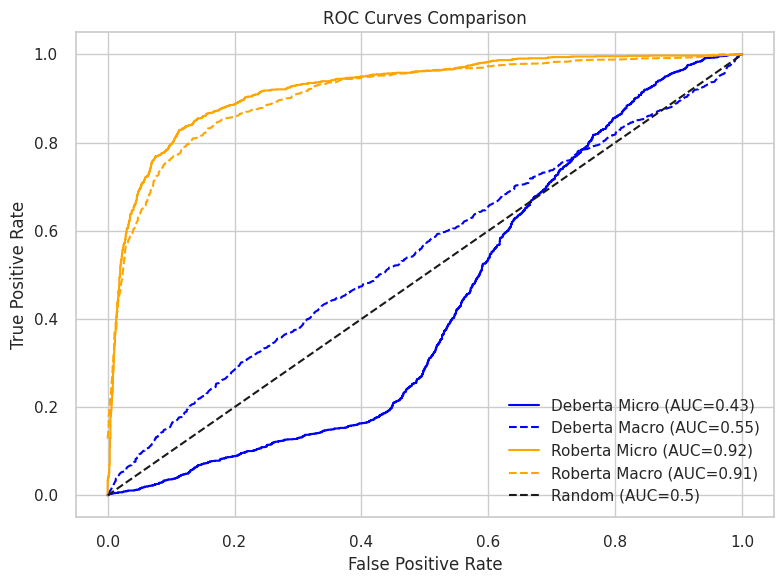

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))
classes = ['positive', 'negative', 'neutral']
y_true_bin = label_binarize(y_test, classes=classes)
# DeBERTa/RoBERTa - Micro/Macro
for model in ['deberta', 'roberta']:
    color = 'blue' if model == 'deberta' else 'orange'
    
    micro_probs = np.vstack([results_df[f'{model}_{cls}'] for cls in classes]).T.ravel()
    fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), micro_probs)
    auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, 
             color=color, linestyle='-', 
             label=f'{model.title()} Micro (AUC={auc_micro:.2f})')

    fprs, tprs = [], []
    for cls in classes:
        fpr, tpr, _ = roc_curve(y_true_bin[:, classes.index(cls)], results_df[f'{model}_{cls}'])
        fprs.append(fpr)
        tprs.append(tpr)
    
    all_fpr = np.unique(np.concatenate(fprs))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fprs[i], tprs[i])
    mean_tpr /= len(classes)
    auc_macro = auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr, 
             color=color, linestyle='--', 
             label=f'{model.title()} Macro (AUC={auc_macro:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()